# Dynamic Time Warping

I recently moved into a role in a marketing company, and, specifically, into the analytics department. Much of my career has been spent on machine learning optimisation and model building and much of my hobby time has been on using this knowledge in the audio space, so this was a new domain for me. In my training I always avoided time series analysis as it seemed very stale and very one dimensional - I could not have been more wrong!

Having acquired a foundational understanding of both spend and impressions (foundational concepts in marketing analytics), alongside a grasp of the principles underlying mathematical and econometric modeling, and with a bit of domain knowledge to complement, I decided it was time to start experimenting with different ways to look at and compare the data using ominous statistical methods (is this not the zen of a data scientist?).

Enter Dynamic Time Warping (DTW)..

Dynamic Time Warping is a powerful tool for analysing time series data, that was initially developed in the 1970's to compare speech and word recognition with sound waves as a source. It offers a way to compare the similarity of time series data in ways that traditional methods might miss.

In this article I will try to explain the basic concepts, some of its underlying theory and then give a practical example using my favourite language for exploring data - Python.

## Introduction to DTW

At its core, DTW is an algorithm designed to align and compare two time-series datasets. Unlike simpler methods that compare points based on their position in the time sequence, DTW focuses on the shape of the data. This allows it to find the optimal alignment between two time series by minimizing the distance between them, even if they are out of phase or differ in length.

The main idea is to compute the distance from the matching of similar elements between time series. As an example, imagine two people saying the same sentence, one speaking quickly and one speaking more slowly. If you were to graph the sound waves of each sentence, the shapes would look similar in terms of rises and falls, but they would not line up perfectly all the time axis due to the difference in speak. If you tried to compare these sound waves using a straightforward, point-to-point approach (like Euclidean distance), the comparison would be unfair. It's like trying to synchronize two singers when one is slightly ahead or behind the other; they're singing the same notes, but not at the same time, so a direct comparison at any given moment wouldn't make much sense. 

Lets write some code to show this:

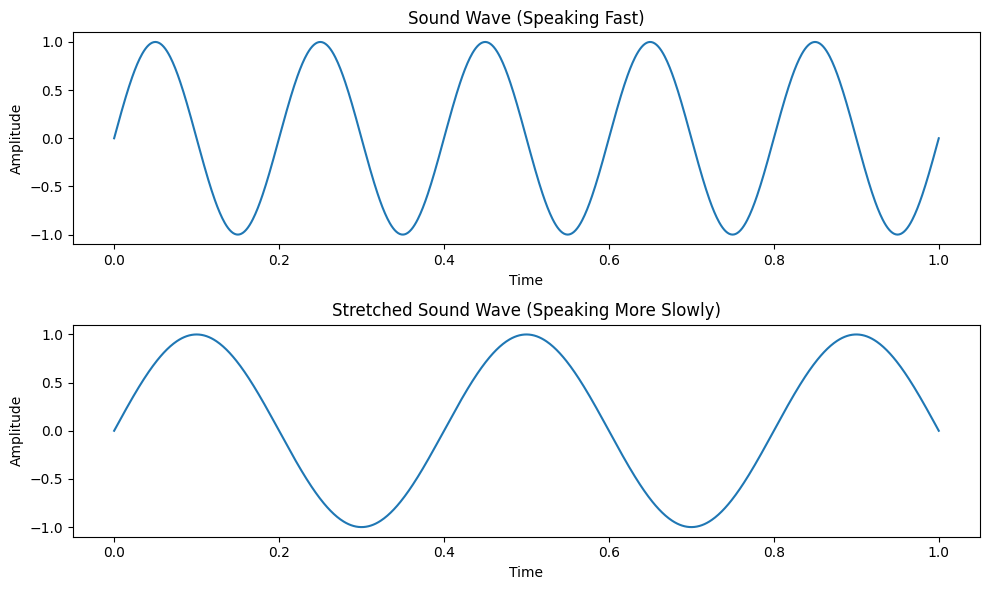

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generating a simple sound wave as an example
t = np.linspace(0, 1, 1000)
sound_wave_fast = np.sin(2 * np.pi * 5 * t)  # 5 Hz tone

# Stretching the sound wave to simulate speaking more slowly
# We'll simulate this by reducing the frequency
sound_wave_slow = np.sin(2 * np.pi * 2.5 * t)  # 2.5 Hz tone, half the original frequency

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plotting the fast speaking sound wave
axs[0].plot(t, sound_wave_fast)
axs[0].set_title('Sound Wave (Speaking Fast)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

# Plotting the stretched sound wave (speaking more slowly)
axs[1].plot(t, sound_wave_slow)
axs[1].set_title('Stretched Sound Wave (Speaking More Slowly)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

At first glance, its not easy to compare the above two graphs or their similariy. DTW is perfect for this, it stretches and compresses the time axes of the sound waves to find the best possible alignment between them. 

Imagine grabbing the wave of the faster speaker and stetching it out so that the syllables and pauses match up. Dynamic time warping effectively 'warps' the data to make sure each point in one series is matched with the most relevant points in the other series, regardless of their position in time. This makes it great for a whole host of applications.

## Applications

Dynamic time warping has been applied in many fields including:

- Speech Recognition: We have just seen an example of this above
- Financial analysis: Comparing stock market trends that are not immediately visible
- Healthcare - Analysing DNA or heartbeat signals
- Marketing - Brand lift analysis, website impression patterns

## Under the hood

Dynamic time warping works by computing the distance between two time series, A and B, by finding a path through a cost matrix that minimizes the cumulative distances between them. There are many ways to calculate this distance, Euclidean distance or Manhatten distances are examples. For those of you that are mathematically inclined, go and check out Romain's [article](https://rtavenar.github.io/blog/dtw.html).

Herman Kamper, a fellow South African, has an absolutely brilliant playlist of videos explain, intuitively, DTW and finding the optimal path on simple data, I highly recommend his videos. The playlist can be found [here[(https://youtu.be/ERKDHZyZDwA?si=3pMgGaKLJULfkGn3)]

Formally, DTW distance can be defined as:

$$ DTW(A,B) = \min \sqrt{\sum_{i,j} d(a_i, b_j)^2} $$

where \( d(a_i, b_j) \) is the distance between points \( a_i \) from series \( A \) and \( b_j \) from series \( B \), and the sum is taken over all points \( (i, j) \) in the optimal alignment path.

Ok, boring stuff out the way, lets get our teeth into a practical example.

We start by importing all the relevant libraries:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from dtaidistance import dtw
from scipy.stats import pearsonr
import pandas as pd


Most of these libraries should be pretty intuitive, the installation instructions for the DTAIdistance library, the one we will use today, can be found [here](https://dtaidistance.readthedocs.io/).

Next we will generate some dummy data for two different datasets. The first generates a 20 random numbers and then uses 'cumsum' from Numpy to cumulatively add them together, simulating a random walk from the starting point. The second data generates 30 random numbers and adds some random oscillations to make the dataset different. A random seed is generated for reproducibility.


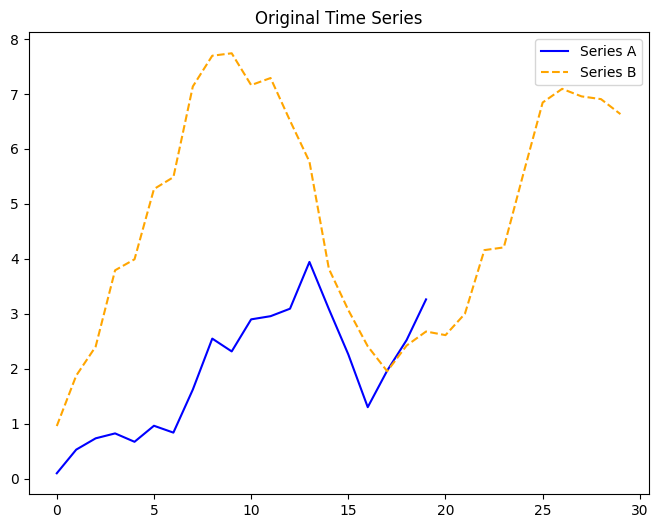

In [12]:
np.random.seed(0)
time_series_a = np.cumsum(np.random.rand(20) * 2 - 1)
time_series_b = np.cumsum(np.random.rand(30) * 2 - 1 + np.sin(np.linspace(0, 3 * np.pi, 30)))

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plotting the time series
ax1.plot(time_series_a, label='Series A', color='blue')
ax1.plot(time_series_b, label='Series B', linestyle='--', color='orange')

# Setting the title and legend
ax1.set_title('Original Time Series')
ax1.legend()

plt.show()

Notice that Series A has less points than Series B. 

Using the DTAIDistance library we then compute the DTW distance and obtain the optimal path that minimally aligns both time series. I really suggest looking at [Hermans](https://youtu.be/ERKDHZyZDwA?si=3pMgGaKLJULfkGn3) videos to understand what the optimal path is and how to calulate it. We then calculate the similarity score of the two time series by working out the average distance between points, a lower score would equate to more similarity.


In [14]:
distance, paths = dtw.warping_paths(time_series_a, time_series_b, use_c=False)
best_path = dtw.best_path(paths)
similarity_score = distance / len(best_path)

Now, lets create a visualisation that has the original time series data, a shortest path visualisation and a plot to show the point-to-point mapping created from DTW:

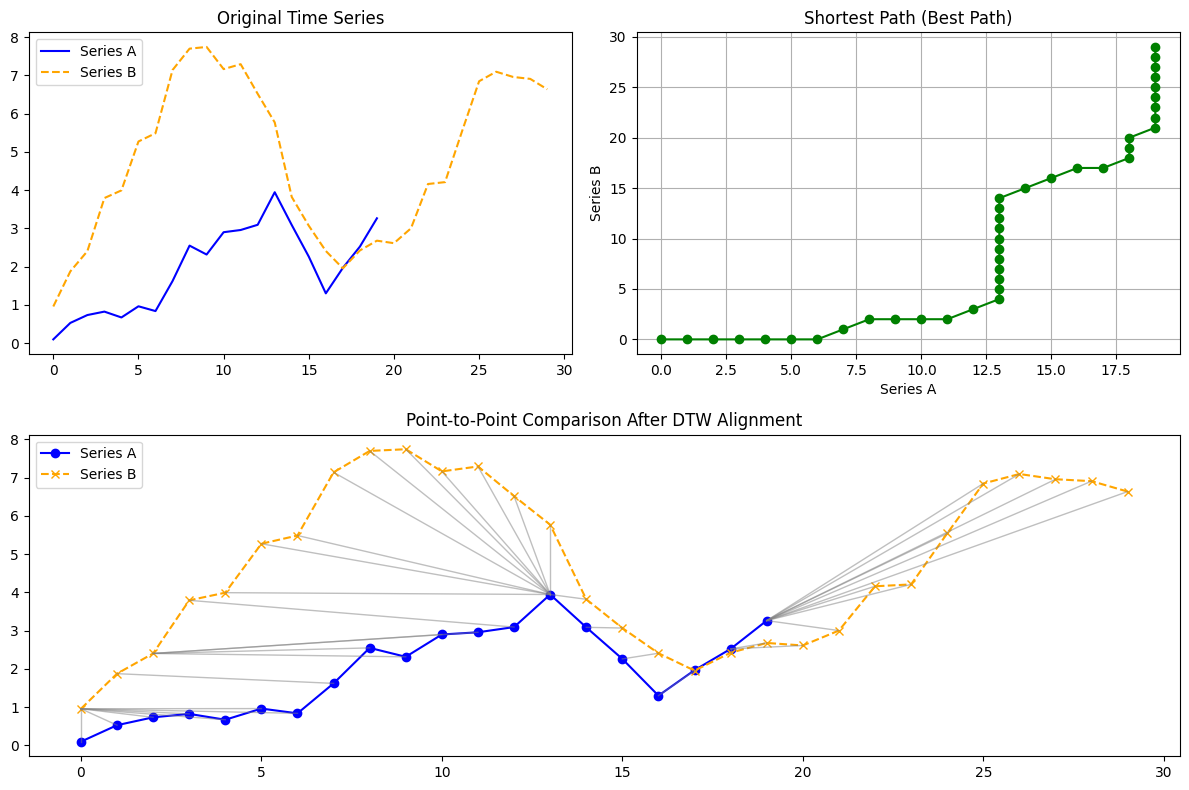

In [15]:
plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(time_series_a, label='Series A', color='blue')
ax1.plot(time_series_b, label='Series B', linestyle='--',color='orange')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
# In this example, only the path is plotted, not the entire cost matrix.

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('Series A')
ax2.set_ylabel('Series B')
ax2.grid(True)

# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(time_series_a, label='Series A', color='blue', marker='o')
ax3.plot(time_series_b, label='Series B', color='orange', marker='x', linestyle='--')
for a, b in best_path:
    ax3.plot([a, b], [time_series_a[a], time_series_b[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

And finally, a dataframe to output the similarity score generated by the DTW:


In [17]:

results_df = pd.DataFrame({
    'Metric': ['DTW Similarity Score'],
    'Value': [similarity_score]
})

results_df['Description'] = [
    "Lower scores indicate greater similarity between the time series."
]

results_df

,Metric,Value,Description
0,DTW Similarity Score,0.306018,Lower scores indicate greater similarity betwe...


## What do these plots show?

### The Shortest Path graph

The "Shortest Path (Best Path)" plot visualises the optimal alignment path determined by the DTW algorithm between the two time series. In this plot:

- The horizontal axis represents the index of points in Series A.
- The vertical axis represents the index of points in Series B.

The green dots represent the mapping of points from Series A to Series B that DTW has found as the best alignment. The line connecting these points demonstrates the sequence in which the points in Series A map to points in Series B. 

A step up indicates that a single point in Series A corresponds to multiple points in Series B, suggesting that in that segment, Series B moves slower (or has more detail) than Series A. A step to the right indicates the opposite, where a single point in Series B maps to multiple points in Series A. A diagonal move indicates a one-to-one mapping, showing that both series progress at the same pace.

Reading the plot gives an understanding of how the two time series are related in time. In the regions where the plot steps up or right more than it moves diagonally, there are speed differences between the series. This plot is a way of visualizing how we might need to stretch or compress the time axis of the time series to align them for a direct comparison. For example, the diagonal parts indicate segements where the two series are 'in sync' or have similar pacing, which could indicate similar behaviour over those periods. A horizonal line may indicate relative stability against the other series which may be more volatile in comparison.

### The 'point-to-point' graph

The "Point-to-Point Comparison After DTW Alignment" plot illustrates the actual alignment of the two time series based on the optimal path from DTW algorithm:

Each point in Series A (blue line with circles) is connected by a gray line to its corresponding point in Series B (orange dashed line with crosses), as determined by DTW. The direct connections between the points highlight the warping of the time axis and show how specific points in one series align with those in another. For example, a peak in series A may correspond to a peak in Series B even if they occur at different times in the original series. This alignment accounts for variations in speed or timing between the series. Basically, its a visalisation of the 'warping' that DTW suggests for aligning the two sequences.

Shorter lines indicate closer matches between the series at those points, longer lines show the stretching that was needed to align them.

Lets print out the actual DTW similarity score in a dataframe:

In [20]:

results_df = pd.DataFrame({
    'Metric': ['DTW Similarity Score'],
    'Value': [similarity_score]
})

# Add descriptions for the results
results_df['Description'] = [
    "Lower scores indicate greater similarity between the time series."
]

results_df

,Metric,Value,Description
0,DTW Similarity Score,0.306018,Lower scores indicate greater similarity betwe...


A score of 0 would mean that both series were identical. A score of 1 would mean that they are not similar at all. Anything in between is relative, so scores under 0.5 indicate more similarity and > 0.5 indicate less similarity. So in this case a score of 0.3 indicates there is similarity. This metric is not very valuable on its own, but when used in conjunction with the above graphs can give information on similarity between the two sequences.

## In conclusion...

This is a very top-line overview of the power of DTW, it is valuable not only for direct comparisons but facilitates complex analysis and interpretation of the underlying time series. It can be coupled with various other techniques to enhance its value, for example, it can be used for feature engineering in machine learning algorithms and fed into models such as Random Forests or Deep Learning models. It is also used frequently in clustering algorithms such as K-means to group similar time series together. I've also seen it being used in data augmentation, to create synthetic time series data based on existing time series sequences to provide additional data for training robust models.

Here is the full code for completeness:

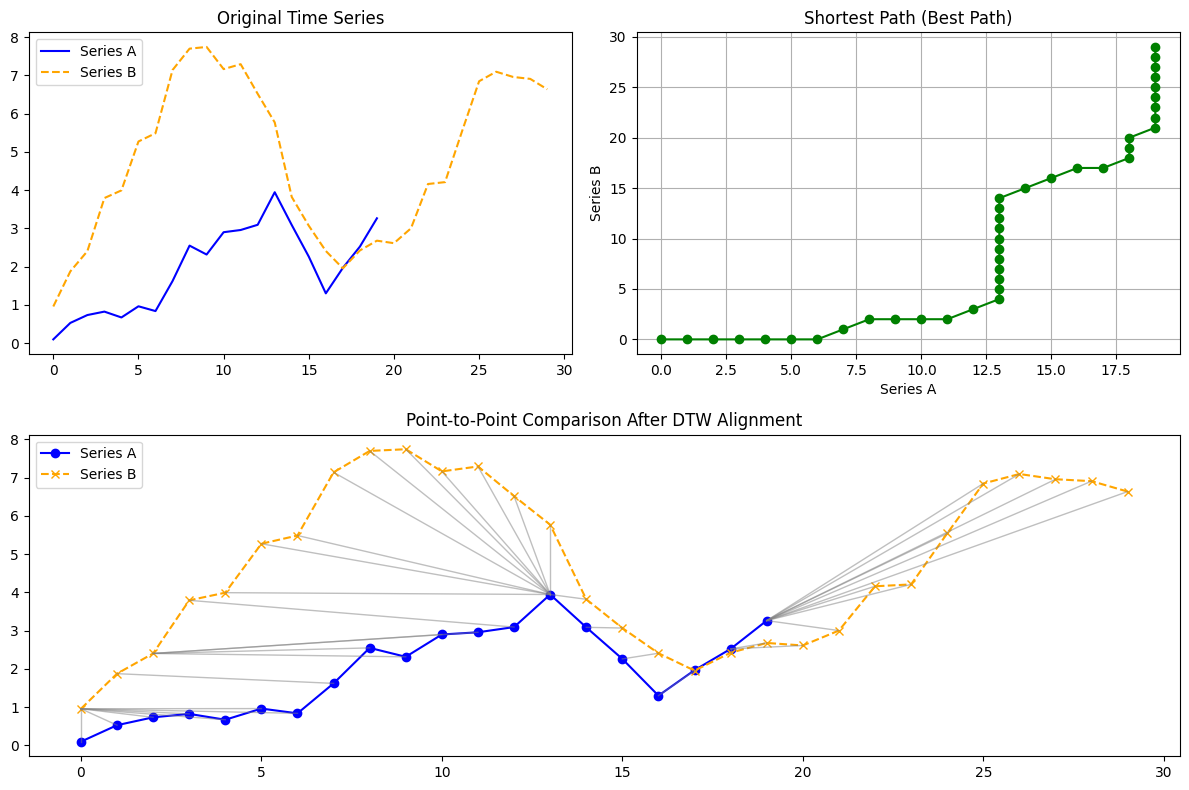

,Metric,Value,Description
0,DTW Similarity Score,0.306018,Lower scores indicate greater similarity betwe...


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from dtaidistance import dtw
from scipy.stats import pearsonr
import pandas as pd

# Generate dummy data for the time series

np.random.seed(0)
time_series_a = np.cumsum(np.random.rand(20) * 2 - 1)
time_series_b = np.cumsum(np.random.rand(30) * 2 - 1 + np.sin(np.linspace(0, 3 * np.pi, 30)))

# Calculate DTW distance and obtain the warping paths (no need for the C library)
distance, paths = dtw.warping_paths(time_series_a, time_series_b, use_c=False)
best_path = dtw.best_path(paths)

similarity_score = distance / len(best_path)

plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(time_series_a, label='Series A', color='blue')
ax1.plot(time_series_b, label='Series B', linestyle='--',color='orange')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
# In this example, only the path is plotted, not the entire cost matrix.

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('Series A')
ax2.set_ylabel('Series B')
ax2.grid(True)


# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(time_series_a, label='Series A', color='blue', marker='o')
ax3.plot(time_series_b, label='Series B', color='orange', marker='x', linestyle='--')
for a, b in best_path:
    ax3.plot([a, b], [time_series_a[a], time_series_b[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

# Create a DataFrame to display the similarity score and correlation coefficient
results_df = pd.DataFrame({
    'Metric': ['DTW Similarity Score'],
    'Value': [similarity_score]
})

# Add descriptions for the results
results_df['Description'] = [
    "Lower scores indicate greater similarity between the time series."
]

results_df
